# Tiramisu for Segmentation

In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

Using TensorFlow backend.


In [2]:
import scipy.ndimage as pic
from concurrent.futures import ProcessPoolExecutor

## Setup

In [3]:
PATH =''
frames_path = PATH+'Train/'
dot_path = PATH+'TrainDotted/'

In [4]:
fnames = glob.glob(frames_path+'*.jpg')
print (fnames[0:3])

['Train/47.jpg', 'Train/43.jpg', 'Train/44.jpg']


In [5]:
dnames = [dot_path+os.path.basename(fn)[:-4]+'.jpg' for fn in fnames]
print (dnames[0:3])

['TrainDotted/47.jpg', 'TrainDotted/43.jpg', 'TrainDotted/44.jpg']


In [6]:
img_sz = (360,360)

In [7]:
def open_image(fn): return np.array(Image.open(fn).resize(img_sz, Image.NEAREST))

In [8]:
imgs = np.stack([open_image(fn) for fn in fnames])
imgs.shape

(10, 360, 360, 3)

In [36]:
imgs = imgs/255.

In [37]:
mean = imgs.mean() 
std = imgs.std()
mean, std

(0.47389365871863176, 0.16197702783842294)

In [38]:
imgs-=mean
imgs/=std

In [39]:
save_array(PATH+'results/imgs.bc', imgs)

In [40]:
imgs = load_array(PATH+'results/imgs.bc')

In [41]:
n,r,c,ch = imgs.shape

In [9]:
cord = pd.read_csv('coords.csv')
cord.cls = cord.cls+1

### Codes

In [10]:
seal = ['void', 'adult_males', 'subadult males', 'adult females', 'juveniles', 'pups']
rgb = [(0,0,0), (243,8,5), (244,8,242), (87,46,10), (25,56,176), (38,174,21)]  
cls = [0, 1, 2, 3, 4, 5]
hex = ['#000000', '#f30805', '#f408f2', '#572e0a', '#1938b0', '#26ae15']

In [11]:
seal2rgb = dict(zip(seal,rgb))
cls2rgb = dict(zip(cls, rgb))
cls2hex = dict(zip(cls, hex))
seal2cls = dict(zip(seal,cls))
cls2seal = dict(zip(cls,seal))
rgb2cls = dict(zip(rgb, cls))

### Labelling-Hardcore

In [12]:
img_sz = (360,360)

In [13]:
def open_image(fn): return np.array(Image.open(fn).resize(img_sz, Image.NEAREST))
imgs= np.stack([open_image(fn) for fn in fnames])
imgs.shape

(10, 360, 360, 3)

In [14]:
imgs[0].shape[:2]

(360, 360)

In [15]:
def create_labels(x,r=1):
    for i in range(-r,r):
        for j in range(-r,r):
            row = int((x['row']*img_sz[0])/actual.shape[0])
            col = int((x['col']*img_sz[1])/actual.shape[1])
            if (row+i)<img_sz[0] and (col+j)<img_sz[1]:
                label[(row + i), (col + j)] = x['cls'] # row,column

In [16]:
import sys

In [17]:
%%time
target = []
for i in range(imgs.shape[0]):
    print('Processing for image = '+fnames[i])
    actual = pic.imread(fnames[i])
    x=fnames[i]
    id = int(x[6:].split('.')[0])
    cordinates = cord[cord.tid==id]
    label = np.zeros(img_sz,dtype=int)
    a=cordinates.apply(create_labels, axis=1)
    target.append(label)

Processing for image = Train/47.jpg
Processing for image = Train/43.jpg
Processing for image = Train/44.jpg
Processing for image = Train/45.jpg
Processing for image = Train/48.jpg
Processing for image = Train/42.jpg
Processing for image = Train/50.jpg
Processing for image = Train/49.jpg
Processing for image = Train/46.jpg
Processing for image = Train/41.jpg
CPU times: user 2.68 s, sys: 312 ms, total: 2.99 s
Wall time: 2.97 s


In [18]:
labels_int = np.array(target)

In [19]:
labels_int.shape

(10, 360, 360)

In [20]:
def color_label(a): 
    r,c=a.shape
    res = np.zeros((r,c,3), 'uint8')
    for j in range(r): 
        for k in range(c):
            o=cls2rgb[a[j,k]]
            res[j,k] = o
    return res

In [21]:
col_label = color_label(labels_int[1])
fnames[1]

'Train/43.jpg'

In [22]:
cord[cord.tid==44]['cls'].value_counts()

3    25
4    15
1     3
2     2
Name: cls, dtype: int64

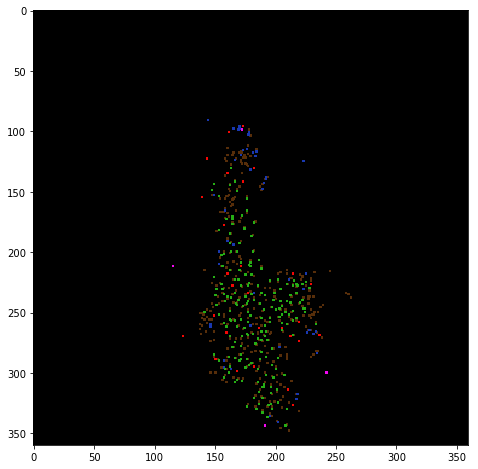

In [23]:
plt.figure(figsize=(8,8))
plt.imshow(col_label)

In [24]:
dot = imgs[9]

In [25]:
for x in range(360):
    for y in range(360):
        if target[9][x,y]!=0:
            dot[x,y] = col_label[x,y]

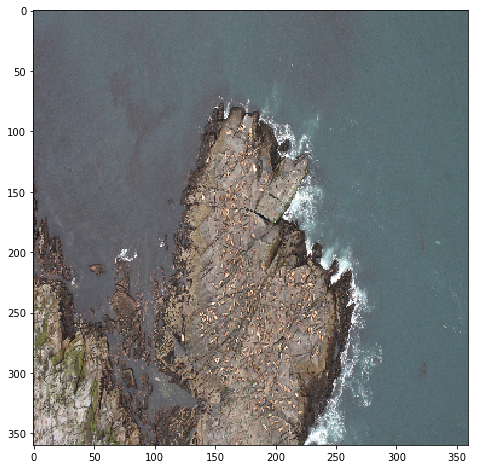

In [26]:
plt.figure(figsize=(8,8))
plt.imshow(imgs[1])

In [46]:
! mkdir labels

In [27]:
save_array(PATH+'labels/labels_int.bc', labels_int)

In [28]:
labels_int = load_array(PATH+'labels/labels_int.bc')

In [29]:
for i in range(6):
    print('for class '+str(i)+' = '+str(np.count_nonzero(label==i)))

for class 0 = 128918
for class 1 = 60
for class 2 = 0
for class 3 = 320
for class 4 = 69
for class 5 = 233


In [30]:
cordinates.cls.value_counts()

3    85
5    59
4    18
1    15
Name: cls, dtype: int64

## Processing

### Generator

In [42]:
class BatchIndices(object):
    def __init__(self, n, bs, shuffle=False):
        self.n,self.bs,self.shuffle = n,bs,shuffle
        self.lock = threading.Lock()
        self.reset()

    def reset(self):
        self.idxs = (np.random.permutation(self.n) 
                     if self.shuffle else np.arange(0, self.n))
        self.curr = 0

    def __next__(self):
        with self.lock:
            if self.curr >= self.n: self.reset()
            ni = min(self.bs, self.n-self.curr)
            res = self.idxs[self.curr:self.curr+ni]
            self.curr += ni
            return res

In [43]:
bi = BatchIndices(10,4)
[next(bi) for o in range(5)]

[array([0, 1, 2, 3]),
 array([4, 5, 6, 7]),
 array([8, 9]),
 array([0, 1, 2, 3]),
 array([4, 5, 6, 7])]

In [44]:
temp = labels_int[0]

In [45]:
class segm_generator(object):
    def __init__(self, x, y, bs=64, out_sz=(224,224), train=True):
        self.x, self.y, self.bs, self.train = x,y,bs,train
        self.n, self.ri, self.ci, _ = x.shape
        self.idx_gen = BatchIndices(self.n, bs, train)
        self.ro, self.co = out_sz
        self.ych = self.y.shape[-1] if len(y.shape)==4 else 1

    def get_slice(self, i,o):
        start = random.randint(0, i-o) if self.train else (i-o)
        return slice(start, start+o)

    def get_item(self, idx):
        condition =True
        while True:
            slice_r = self.get_slice(self.ri, self.ro)
            slice_c = self.get_slice(self.ci, self.co)
            x = self.x[idx, slice_r, slice_c]
            y = self.y[idx, slice_r, slice_c]
            if self.train and (random.random()>0.5): 
                y = y[:,::-1]
                x = x[:,::-1]
            # Modified to create patches with atleast one sea lion
            if np.sum(y)!=0:
                break
        return x, y

    def __next__(self):
        idxs = next(self.idx_gen)
        items = (self.get_item(idx) for idx in idxs)
        xs,ys = zip(*items)
        return np.stack(xs), np.stack(ys).reshape(len(ys), -1, self.ych)

### Visualizing generator

In [134]:
j, t_la = next(train_generator)

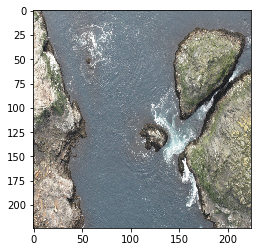

In [135]:
plt.imshow(j[0]*std+mean)

382

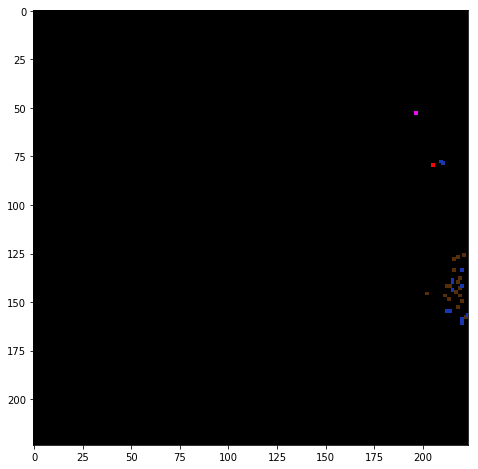

In [165]:
j, t_la = next(train_generator)
plt.figure(figsize=(8,8))
plt.imshow(color_label(np.resize(t_la[0], (224,224))))
np.sum(t_la[0])

In [159]:
t_la.shape

(1, 50176, 1)

## DATA SET

In [166]:
train_set = imgs[:9]
train_labels = labels_int[:9]

test_set = imgs[9:]
test_labels = labels_int[9:]

## Tiramisu

### Pieces

In [168]:
def relu(x): return Activation('relu')(x)
def dropout(x, p): return Dropout(p)(x) if p else x
def bn(x): return BatchNormalization(mode=2, axis=-1)(x)
def relu_bn(x): return relu(bn(x))
def concat(xs): return merge(xs, mode='concat', concat_axis=-1)

In [169]:
def conv(x, nf, sz, wd, p, stride=1): 
    x = Convolution2D(nf, sz, sz, init='he_uniform', border_mode='same', 
                      subsample=(stride,stride), W_regularizer=l2(wd))(x)
    return dropout(x, p)

def conv_relu_bn(x, nf, sz=3, wd=0, p=0, stride=1): 
    return conv(relu_bn(x), nf, sz, wd=wd, p=p, stride=stride)

In [170]:
def dense_block(n,x,growth_rate,p,wd):
    added = []
    for i in range(n):
        b = conv_relu_bn(x, growth_rate, p=p, wd=wd)
        x = concat([x, b])
        added.append(b)
    return x,added

In [171]:
def transition_dn(x, p, wd):
#     x = conv_relu_bn(x, x.get_shape().as_list()[-1], sz=1, p=p, wd=wd)
#     return MaxPooling2D(strides=(2, 2))(x)
    return conv_relu_bn(x, x.get_shape().as_list()[-1], sz=1, p=p, wd=wd, stride=2)

In [172]:
def down_path(x, nb_layers, growth_rate, p, wd):
    skips = []
    for i,n in enumerate(nb_layers):
        x,added = dense_block(n,x,growth_rate,p,wd)
        skips.append(x)
        x = transition_dn(x, p=p, wd=wd)
    return skips, added

In [173]:
def transition_up(added, wd=0):
    x = concat(added)
    _,r,c,ch = x.get_shape().as_list()
    return Deconvolution2D(ch, 3, 3, (None,r*2,c*2,ch), init='he_uniform', 
               border_mode='same', subsample=(2,2), W_regularizer=l2(wd))(x)
#     x = UpSampling2D()(x)
#     return conv(x, ch, 2, wd, 0)

In [174]:
def up_path(added, skips, nb_layers, growth_rate, p, wd):
    for i,n in enumerate(nb_layers):
        x = transition_up(added, wd)
        x = concat([x,skips[i]])
        x,added = dense_block(n,x,growth_rate,p,wd)
    return x

In [175]:
def reverse(a): return list(reversed(a))

In [176]:
def create_tiramisu(nb_classes, img_input, nb_dense_block=6, 
    growth_rate=16, nb_filter=48, nb_layers_per_block=5, p=None, wd=0):
    
    if type(nb_layers_per_block) is list or type(nb_layers_per_block) is tuple:
        nb_layers = list(nb_layers_per_block)
    else: nb_layers = [nb_layers_per_block] * nb_dense_block

    x = conv(img_input, nb_filter, 3, wd, 0)
    skips,added = down_path(x, nb_layers, growth_rate, p, wd)
    x = up_path(added, reverse(skips[:-1]), reverse(nb_layers[:-1]), growth_rate, p, wd)
    
    x = conv(x, nb_classes, 1, wd, 0)
    _,r,c,f = x.get_shape().as_list()
    x = Reshape((-1, nb_classes))(x)
    return Activation('softmax')(x)

## Train

In [177]:
from keras.utils.np_utils import to_categorical
lrg_sz = (224,224)
train_labels.shape,labels_int.shape

((9, 360, 360), (10, 360, 360))

In [178]:
train_generator = segm_generator(train_set, train_labels, 4, out_sz=lrg_sz ,train=True)
test_generator = segm_generator(test_set, test_labels, 4, out_sz=lrg_sz, train=False)

In [182]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5])

### Setting up training

In [183]:
input_shape = lrg_sz+(3,)
img_input = Input(shape=input_shape)

In [184]:
img_input = Input(shape=input_shape)

In [189]:
x = create_tiramisu(6, img_input, nb_layers_per_block=[4,5,7,10,12,15], p=0.2, wd=1e-4)

In [190]:
model = Model(img_input, x)

In [277]:
#loss
def sparse_categorical_crossentropy(y_true, y_pred):
    true = K.clip(y_true,0,1)
    pred = K.clip(y_pred,0,1)
    loss = K.sum(K.clip((true-pred),0,1))
    return (K.sparse_categorical_crossentropy(y_pred, y_true))*loss

In [276]:
sess = tf.InteractiveSession()
a = tf.constant([0,1,2,3,0,0])
a=K.clip(a,0,1)
b = tf.constant([0,0,0,0,1,1])
a=K.sum(K.clip((a-b),0,1))
a.eval(session=sess)

3

#### Start Training

In [278]:
model.compile(loss=sparse_categorical_crossentropy,
              optimizer=keras.optimizers.RMSprop(1e-3), metrics=["accuracy"])

In [279]:
model.optimizer=keras.optimizers.RMSprop(1e-3, decay=1-0.99995)

In [280]:
model.fit_generator(train_generator, len(train_set), nb_epoch=10, verbose=1,
                    validation_data=test_generator, nb_val_samples=len(test_set))

Epoch 1/10
9/9 [==============================] - 86s - loss: 5550.0052 - acc: 0.6789 - val_loss: 609.6550 - val_acc: 1.0000
Epoch 2/10
9/9 [==============================] - 75s - loss: 1349.6147 - acc: 1.0000 - val_loss: 609.4163 - val_acc: 1.0000
Epoch 3/10
9/9 [==============================] - 81s - loss: 786.2348 - acc: 1.0000 - val_loss: 609.3154 - val_acc: 1.0000
Epoch 4/10
9/9 [==============================] - 77s - loss: 1369.9432 - acc: 1.0000 - val_loss: 609.1149 - val_acc: 1.0000
Epoch 5/10
9/9 [==============================] - 77s - loss: 521.5420 - acc: 1.0000 - val_loss: 608.1705 - val_acc: 1.0000
Epoch 6/10
9/9 [==============================] - 78s - loss: 1337.9404 - acc: 1.0000 - val_loss: 601.7705 - val_acc: 1.0000
Epoch 7/10
9/9 [==============================] - 78s - loss: 858.4762 - acc: 0.9877 - val_loss: 609.7176 - val_acc: 1.0000
Epoch 8/10
9/9 [==============================] - 78s - loss: 1025.1534 - acc: 1.0000 - val_loss: 609.6735 - val_acc: 1.0000
Epo

### Testing

In [286]:
try_image = np.array(Image.open('Train/41.jpg').resize((224,224), Image.NEAREST))
try_image = try_image/255.
try_image-=mean
try_image/=std
try_image.shape

(224, 224, 3)

In [298]:
try_preds = model.predict(np.expand_dims(try_image, 0), 1)
try_preds.shape

(1, 50176, 6)

In [305]:
min(try_preds[0][:][:,0])

0.98070854

In [289]:
try_preds = np.argmax(try_preds, axis=-1)

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(color_label(np.resize(try_preds[0], (224,224))))

#### Class Weights

In [159]:
total = np.count_nonzero(labels_int!=10)
cls1 = []
cls0 = []
for i in range(n):
    total = np.count_nonzero(labels_int[i]!=10)
    cls1.append(np.count_nonzero(labels_int[i]==1)/total)
    cls0.append(np.count_nonzero(labels_int[i]==0)/total)

In [160]:
weight=[(1/np.mean(cls0)),(1/np.mean(cls1))] 
clss = [0,1]
class_weights = dict(zip(clss, weight))

In [161]:
np.unique(labels_int)

array([0, 1])

In [162]:
class_weights

{0: 1.0009515218170359, 1: 1051.9480519480519}